# Classification Project: Predicting Cardiovascular Disease
***

**Author:** Ron Lodetti Jr.

## Overview
***
One-paragraph overview of the project, including the bvusiness problem, data, methods, results, and recommendations.

I will use machine larning to predict a perosn will have a heart condition based on other health conditoins.

## Business Problem
***
Cardiovascular diseases are the [leading cause of death](https://en.wikipedia.org/wiki/List_of_causes_of_death_by_rate) worldwide except Africa. A hospital wants to be able to identify patients who are at risk of Cardiovascular disease (CVD) to begin taking preventative measures as early as possible. 

## Data Understanding
***
This dataset, [from kaggle](https://www.kaggle.com/datasets/alphiree/cardiovascular-diseases-risk-prediction-dataset), is a cleaned version of the responses from the CDC's [2021 Behavioral Risk Factor Surveillance System (BRFSS)](https://www.cdc.gov/brfss/annual_data/annual_2021.html)

In [1]:
# Import standard packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImPipeline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, log_loss, roc_auc_score, accuracy_score, precision_score
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split, RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, fbeta_score

In [2]:
# Loading the datasets.
df = pd.read_csv('data/Cardiovascular_Diseases_Risk_Prediction_Dataset.csv')
print(df.shape)
df.head()

(308854, 19)


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


As you can see, we have 308,854 rows, each with 18 feature columns and 1 target column:

* `General_Health`: Respondent's reported general health
* `Checkup`: Time since respondent's last routine checkup
* `Exercise`: Participation in any physical activities or exercises in the past month
* `Heart_Disease`: **(Target)** Respondents that reported having coronary heart disease or myocardial infarction
* `Skin_Cancer`: Respondents that reported having skin cancer
* `Other_Cancer`: Respondents that reported having any other types of cancer
* `Depression`: Respondents that reported having a depressive disorder
* `Diabetes`: Respondents that reported having a diabetes
* `Arthritis`: Respondents that reported having an Arthritis
* `Sex`: Respondent's Gender
* `Age_Category`: Respondent's Age, by category
* `Height_(cm)`: Respondent's Height in centimeters
* `Weight_(kg)`: Respondent's Weight in kilograms
* `BMI`: Body Mass Index
* `Smoking_History`: Respondents that reported having a history of smoking cigarettes
* `Alcohol_Consumption`: Number of days, in the past 30 days, where respondent has had at least one alcoholic beverage
* `Fruit_Consumption`: Number of servings of fruit during the past 30 days
* `Green_Vegetables_Consumption`: Number of servings of vegetables during the past 30 days
* `FriedPotato_Consumption`: Number of servings of fruit during the past 30 days

In [3]:
# There are no missing values. 
# There are 12 features which are object types, 
# we will need to convert these to numeric types.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308854 entries, 0 to 308853
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                308854 non-null  object 
 1   Checkup                       308854 non-null  object 
 2   Exercise                      308854 non-null  object 
 3   Heart_Disease                 308854 non-null  object 
 4   Skin_Cancer                   308854 non-null  object 
 5   Other_Cancer                  308854 non-null  object 
 6   Depression                    308854 non-null  object 
 7   Diabetes                      308854 non-null  object 
 8   Arthritis                     308854 non-null  object 
 9   Sex                           308854 non-null  object 
 10  Age_Category                  308854 non-null  object 
 11  Height_(cm)                   308854 non-null  float64
 12  Weight_(kg)                   308854 non-nul

This data set includes 12 categorical variables (including the target `Heart_Disease`) and 7 numeric variables.

In [4]:
categorical = list(df.select_dtypes(object).columns)
for i in categorical:
    print(i)
    print(df[i].value_counts())
    print('----------\n')

General_Health
Very Good    110395
Good          95364
Excellent     55954
Fair          35810
Poor          11331
Name: General_Health, dtype: int64
----------

Checkup
Within the past year       239371
Within the past 2 years     37213
Within the past 5 years     17442
5 or more years ago         13421
Never                        1407
Name: Checkup, dtype: int64
----------

Exercise
Yes    239381
No      69473
Name: Exercise, dtype: int64
----------

Heart_Disease
No     283883
Yes     24971
Name: Heart_Disease, dtype: int64
----------

Skin_Cancer
No     278860
Yes     29994
Name: Skin_Cancer, dtype: int64
----------

Other_Cancer
No     278976
Yes     29878
Name: Other_Cancer, dtype: int64
----------

Depression
No     246953
Yes     61901
Name: Depression, dtype: int64
----------

Diabetes
No                                            259141
Yes                                            40171
No, pre-diabetes or borderline diabetes         6896
Yes, but female told only during p

Of our 12 categorical variables:
* There are 8 variables that have no order to them and will need to be OneHotEncoded.
* There are 3 ordinal variables, that is, categories which have an order. These include `General_Health`, `Checkup`, and `Age_Category`.

In [5]:
# Identifying ordinal variables and removing them from categorical
ordinal = ['General_Health', 'Checkup', 'Age_Category']
for i in ordinal:
    categorical.remove(i)
categorical.remove('Heart_Disease')

In [6]:
# These numeric variables are scaled differently and will need to be 
# normalized before including them in specific models

# Max and min values seem reasonable given context. 

numeric = list(df.select_dtypes(exclude=object).columns)
df[numeric].describe()

,Height_(cm),Weight_(kg),BMI,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
count,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000,308854.000000
mean,170.615249,83.588655,28.626211,5.096366,29.835200,15.110441,6.296616
std,10.658026,21.343210,6.522323,8.199763,24.875735,14.926238,8.582954
min,91.000000,24.950000,12.020000,0.000000,0.000000,0.000000,0.000000
25%,163.000000,68.040000,24.210000,0.000000,12.000000,4.000000,2.000000
50%,170.000000,81.650000,27.440000,1.000000,30.000000,12.000000,4.000000
75%,178.000000,95.250000,31.850000,6.000000,30.000000,20.000000,8.000000
max,241.000000,293.020000,99.330000,30.000000,120.000000,128.000000,128.000000


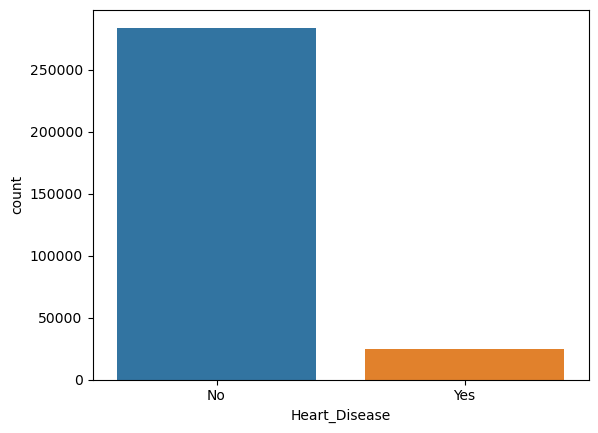

In [7]:
# Our target variable is very imbalanced.
g = sns.countplot(data = df, x= "Heart_Disease")
plt.show();

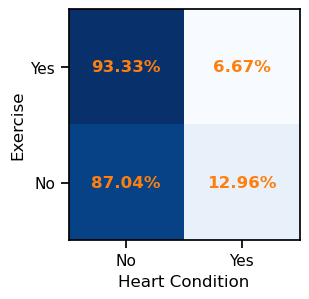

----------



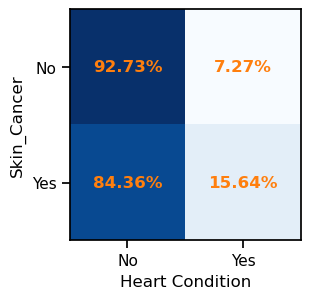

----------



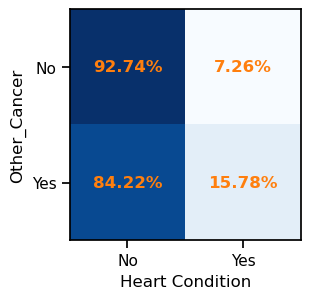

----------



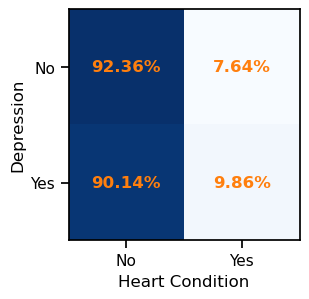

----------



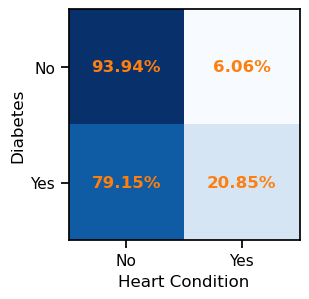

----------



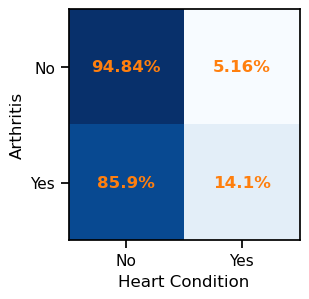

----------



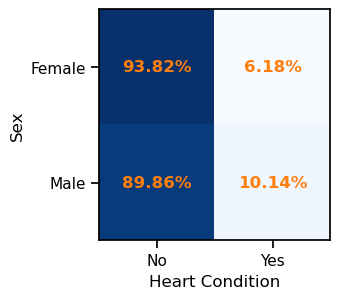

----------



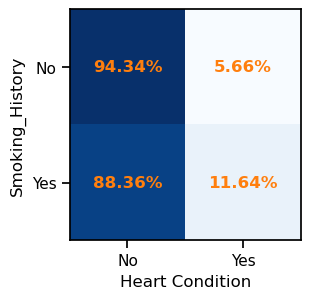

----------



In [8]:
import seaborn as sns
sns.set_context(context='notebook')
for cat in categorical:
    resp = df[cat].value_counts().index
    nn = ((df[cat]==resp[0]) & (df['Heart_Disease']=='No')).sum()/(df[cat]==resp[0]).sum()
    ny = ((df[cat]==resp[0]) & (df['Heart_Disease']=='Yes')).sum()/(df[cat]==resp[0]).sum()
    yn = ((df[cat]==resp[1]) & (df['Heart_Disease']=='No')).sum()/(df[cat]==resp[1]).sum()
    yy = ((df[cat]==resp[1]) & (df['Heart_Disease']=='Yes')).sum()/(df[cat]==resp[1]).sum()
    num = [nn, yn, ny, yy]

    fig, ax = plt.subplots(figsize=(3,3))
    im = ax.imshow([[nn, ny],[yn,yy]],cmap='Blues')
    for i,j in enumerate(num):
        text = str(round(j*100,2))+'%'
        ax.text(i//2, i%2, text,ha="center", va="center", color="tab:orange", weight="bold")
    ax.set(xticks= [0,1],
           xticklabels= ['No','Yes'],
           xlabel = 'Heart Condition',
           yticks= [0,1],
           yticklabels= [resp[0], resp[1]],
           ylabel = cat
          )
    plt.show();
    print('----------')
    print('')

## Data Preparation
***

In [9]:
# Splitting the training from the validation data
# Making sure the split is stratefied given teh imbalance of our target variable
y = df['Heart_Disease']
X = df.drop('Heart_Disease',axis=1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=12, stratify= y)

In [10]:
print('Training Target Distribution')
print(y_train.value_counts(normalize=True))
print('')
print('Validation Target Distribution')
print(y_test.value_counts(normalize=True))

Training Target Distribution
No     0.91915
Yes    0.08085
Name: Heart_Disease, dtype: float64

Validation Target Distribution
No     0.919147
Yes    0.080853
Name: Heart_Disease, dtype: float64


In [11]:
# Transforming the target variable into 1's and 0's
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [12]:
# Instantiating an OrdinalEncoder transformer to encode ordinal variables. 

# Listing categories in order for each ordinal variable.
health = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
check = [
    'Never', '5 or more years ago', 'Within the past 5 years',
    'Within the past 2 years', 'Within the past year'
]
age = [
    '18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59',
    '60-64', '65-69', '70-74', '75-79', '80+'
]
oe = OrdinalEncoder(categories=[health, check, age])


In [13]:
# Instantiating a OneHotEncoder transformer to be used on the categorical varaibles. 
ohe = OneHotEncoder()

In [14]:
# Creating a column transformer to be used in a pipeline
ct = ColumnTransformer(transformers=[
    ('oe', OrdinalEncoder(categories=[health, check, age]), ordinal),
    ('ohe', OneHotEncoder(), categorical)
], remainder="passthrough")

## Data Modeling
***

In [15]:
def model_scores(model, X, y, model_list= [], cv= 5, model_name = ''):
    if cv>1:
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=12)
        scoring = {'f2': make_scorer(fbeta_score, beta=2),
                   'accuracy':'accuracy',
                   'precision': 'precision',
                   'recall': 'recall',
                   'roc_auc':'roc_auc'}
        scores = cross_validate(model,
                               X,
                               y,
                               scoring = scoring,
                               cv=skf,
                               n_jobs=-1)
        f2 = round(scores['test_f2'].mean(),4)*100
        accuracy = round(scores['test_accuracy'].mean(),4)*100
        precision = round(scores['test_precision'].mean(),4)*100
        recall = round(scores['test_recall'].mean(),4)*100
        roc_auc = round(scores['test_roc_auc'].mean(),4)*100
    else:
        y_preds = model.predict(X)
        f2 = round(fbeta_score(y,y_preds,beta=2),4)*100
        recall = round(recall_score(y,y_preds),4)*100
        accuracy = round(accuracy_score(y,y_preds),4)*100
        precision = round(precision_score(y,y_preds, zero_division=0.0),4)*100
        roc_auc = round(roc_auc_score(y,y_preds),4)*100
    model_list.append([model_name, f2, accuracy, precision, recall, roc_auc])
    df = pd.DataFrame(model_list, columns=['name', 'f2', 'accuracy', 'precision', 'recall',  'roc_auc'])
    return model_list, df

### Dummy Model

In [16]:

pipe = Pipeline(steps=[('ct', ct),
                      ('dm', DummyClassifier(strategy='most_frequent'))])
dummy_model = pipe.fit(X_train, y_train)
ml, mdf = model_scores(dummy_model, X_train, y_train, model_list= [], cv= 5, model_name = 'Dummy Model')
mdf

,name,f2,accuracy,precision,recall,roc_auc
0,Dummy Model,0.0,91.92,0.0,0.0,50.0


### Baseline Model

In [17]:
classifiers = {
    "LogisticRegression": LogisticRegression(random_state=12),  
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=12),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "GaussianNB": GaussianNB()
}
ml2 = []
for key in classifiers:
    classifier = classifiers[key]
    pipe = Pipeline(steps=[('ct',ct),
                           ('ss',StandardScaler()),
                           (key, classifier)])
   
    model = pipe.fit(X_train, y_train)
    ml2, mdf2 = model_scores(model, X_train, y_train, model_list= ml2, cv= 5, model_name = key)
mdf2

,name,f2,accuracy,precision,recall,roc_auc
0,LogisticRegression,7.50,91.94,51.39,6.18,83.41
1,DecisionTreeClassifier,22.30,86.14,19.63,23.09,57.39
2,KNeighborsClassifier,10.67,91.02,31.21,9.16,68.49
3,GaussianNB,41.58,77.76,19.79,57.37,78.01


In [18]:
pipe = Pipeline(steps=[('ct', ct),
                      ('dm', GaussianNB())])
baseline_model = pipe.fit(X_train, y_train)
ml, mdf = model_scores(baseline_model, X_train, y_train, model_list= ml, cv= 5, model_name = 'Baseline Model')
mdf

,name,f2,accuracy,precision,recall,roc_auc
0,Dummy Model,0.00,91.92,0.00,0.00,50.00
1,Baseline Model,41.58,77.76,19.79,57.37,78.01


### Model Iteration

In [19]:
classifiers = {
    'RandomForestClassifier': RandomForestClassifier(random_state=12),  
    'XGBClassifier': XGBClassifier(random_state=12)}
ml3 = []
for key in classifiers:
    classifier = classifiers[key]
    pipe = Pipeline(steps=[('ct',ct),
                           (key, classifier)])
   
    model = pipe.fit(X_train, y_train)
    ml3, mdf3 = model_scores(model, X_train, y_train, model_list= ml3, cv= 5, model_name = key)
mdf3

,name,f2,accuracy,precision,recall,roc_auc
0,RandomForestClassifier,5.34,91.81,43.76,4.38,80.85
1,XGBClassifier,6.22,91.89,48.57,5.10,82.99


In [20]:
# Choose between XGBClassifier Variants

# Basic
pipe = Pipeline(steps=[('ct', ct),
                       ('xgb', XGBClassifier(random_state=12))])
xgb_model = pipe.fit(X_train, y_train)
ml4, mdf4 = model_scores(xgb_model, X_train, y_train, model_list = [], model_name= "Basic XGB")

# Weighted
pipe = Pipeline(steps=[('ct', ct),
                       ('xgb', XGBClassifier(random_state=12,scale_pos_weight=283883/24971))])
xgb_weighted = pipe.fit(X_train, y_train)
ml4, mdf4 = model_scores(xgb_weighted, X_train, y_train, model_list = ml4, model_name= "Weighted XGB")

# SMOTE
pipe = ImPipeline(steps=[('ct', ct),
                       ('ss', StandardScaler()),
                       ('sm',SMOTE(random_state=12)),
                       ('xgb', XGBClassifier(random_state=12))])
xgb_smote = pipe.fit(X_train, y_train)
ml4, mdf4 = model_scores(xgb_smote, X_train, y_train, model_list = ml4, model_name= "SMOTE XGB")

# ADASYN
pipe = ImPipeline(steps=[('ct', ct),
                       ('ss', StandardScaler()),
                       ('sm',ADASYN(random_state=12)),
                       ('xgb', XGBClassifier(random_state=12))])
xgb_adasyn = pipe.fit(X_train, y_train)
ml4, mdf4 = model_scores(xgb_adasyn, X_train, y_train, model_list = ml4, model_name= "ADASYN XGB")
mdf4

,name,f2,accuracy,precision,recall,roc_auc
0,Basic XGB,6.22,91.89,48.57,5.10,82.99
1,Weighted XGB,49.27,74.52,20.62,75.49,82.41
2,SMOTE XGB,6.75,91.81,44.54,5.57,82.81
3,ADASYN XGB,5.84,91.78,42.56,4.81,82.82


In [21]:
# Randomize the Weighted
pipe = Pipeline(steps=[('ct', ct),
                       ('xbg', XGBClassifier(random_state=12,tree_method='hist', scale_pos_weight= 283883/24971))])

params = {
    'xbg__n_estimators': range(50,1000,50),
    'xbg__max_depth': range(1,15),
    'xbg__eta': [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'xbg__colsample_bytree': np.linspace(0,1,50),
    'xbg__min_child_weight': range(1,10),
    'xbg__gamma': [0, 0.1, 1, 10, 100, 1000],
    'xbg__reg_alpha': [0, 0.01, 0.1, 1, 10],
    'xbg__reg_lambda':[0, 0.01, 0.1, 1, 10]
}
ftwo_scorer = make_scorer(fbeta_score, beta=2)

rs = RandomizedSearchCV(estimator= pipe, param_distributions= params,
                       n_iter=500, scoring=ftwo_scorer, n_jobs=-1, cv=5, random_state=12)
rand_search = rs.fit(X_train, y_train)
rand_model = rand_search.best_estimator_
ml5, df5 = model_scores(rand_model, X_train, y_train, model_list= [], cv= 5, model_name = 'Best Estimator from RS')
print(rand_search.best_params_)
df5

{'xbg__reg_lambda': 10, 'xbg__reg_alpha': 0.1, 'xbg__n_estimators': 650, 'xbg__min_child_weight': 1, 'xbg__max_depth': 4, 'xbg__gamma': 10, 'xbg__eta': 0.15, 'xbg__colsample_bytree': 0.42857142857142855}


,name,f2,accuracy,precision,recall,roc_auc
0,Best Estimator from RS,50.32,72.72,20.18,80.33,83.63


In [22]:
# GridSearching the winnfer for the final
xgb = XGBClassifier(reg_lambda= 10, 
              reg_alpha= 0.1,
              min_child_weight= 1,
              gamma= 10,
              colsample_bytree= 0.42857142857142855,
              tree_method= "hist",
              scale_pos_weight=283883/24971,
              random_state=12)

pipe = Pipeline(steps=[('ct', ct),
                       ('xbg', xgb)])

params = {'xbg__n_estimators': np.linspace(400,800,10,dtype=int),
          'xbg__max_depth': [2,3,4,5,6,7],
          'xbg__eta': np.linspace(0.1,0.2,10)
         }

gs = GridSearchCV(pipe, param_grid= params, scoring=ftwo_scorer, n_jobs=-1, cv=5, verbose= 3)

g_search = gs.fit(X_train, y_train)
gs_model = g_search.best_estimator_
ml5, df5 = model_scores(gs_model, X_train, y_train, model_list= ml5, cv= 5, model_name = 'Best Estimator from GS')
print(rand_search.best_params_)
df5

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
{'xbg__reg_lambda': 10, 'xbg__reg_alpha': 0.1, 'xbg__n_estimators': 650, 'xbg__min_child_weight': 1, 'xbg__max_depth': 4, 'xbg__gamma': 10, 'xbg__eta': 0.15, 'xbg__colsample_bytree': 0.42857142857142855}


,name,f2,accuracy,precision,recall,roc_auc
0,Best Estimator from RS,50.32,72.72,20.18,80.33,83.63
1,Best Estimator from GS,50.46,72.82,20.26,80.44,83.65


In [34]:
import pickle
save_object('rs_params.pkl', rand_search.best_params_)

In [36]:
g_search.best_params_

{'xbg__eta': 0.1, 'xbg__max_depth': 2, 'xbg__n_estimators': 400}

In [37]:
rand_search.best_params_

{'xbg__reg_lambda': 10,
 'xbg__reg_alpha': 0.1,
 'xbg__n_estimators': 650,
 'xbg__min_child_weight': 1,
 'xbg__max_depth': 4,
 'xbg__gamma': 10,
 'xbg__eta': 0.15,
 'xbg__colsample_bytree': 0.42857142857142855}

### Final Model

In [23]:
models_dic = {'Dummy Model': dummy_model,
             'Baseline Model': baseline_model,
             'Final Model':gs_model}
ml=[]
for key in models_dic:
    model = models_dic[key]
    ml, mdf = model_scores(model, X_test, y_test, model_list= ml, cv= 0, model_name = key)
mdf

,name,f2,accuracy,precision,recall,roc_auc
0,Dummy Model,0.00,91.91,0.00,0.00,50.00
1,Baseline Model,41.54,77.72,19.76,57.34,68.43
2,Final Model,50.59,72.71,20.26,80.87,76.43


## Evaluation
***

In [43]:
save_object('g_search.pkl', g_search)


In [44]:
save_model('g_search2.pkl', g_search)

In [ ]:
[mdf, mdf2, mdf3, mdf4, df5]

In [46]:
save_object('mdf.pkl', mdf)
# save_object('mdf2.pkl', mdf2)
# save_object('mdf3.pkl', mdf3)
# save_object('mdf4.pkl', mdf4)
# save_object('df5.pkl', df5)


Since our model fails at two of the assumptions underlying linear regression, we cannot be  be confident in it's results, despite the high R-squared value. 

In [27]:
import joblib

In [28]:
with open('rs_model.pkl', 'wb') as f:
    joblib.dump(rand_model,f)

In [30]:
def save_model(name, model):
    with open(name, 'wb') as f:
        joblib.dump(model,f)

In [31]:
def save_object(name, thing):
    with open(name, 'wb') as f:
        pickle.dump(thing,f)

In [32]:
save_model('gsmodel.pkl', gs_model)

## Conclusion
***


### Recommendations


### Limitations


### Next Steps
